In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.core.debugger import Tracer
from six.moves import cPickle 
from datetime import datetime
import seaborn as sns
import matplotlib as mpl

sns.set(font='DejaVu Sans')
mpl.rcParams['font.family'] = 'DejaVu Sans'

mpl.rcParams['font.sans-serif'].insert(0, 'DejaVu Sans')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['figure.figsize'] = 12, 4

In [3]:

# Fetch data with the following
#
#   wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#   tar xzf cifar-10-python.tar.gz
# 

def load_batch(path):
    # https://stackoverflow.com/questions/35995999/why-cifar-10-images-are-not-displayed-properly-using-matplotlib
    f = open(path, 'rb')
    datadict = cPickle.load(f,encoding='latin1')
    f.close()
    X = datadict["data"] 
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float32")
    X = X.reshape(10000, -1)
    Y = np.array(Y)
    return X, Y

im_batches = []
all_labels = []
for i in [1,2,3,4,5]:
    ims, labs = load_batch('/home/nbuser/cifar-10-batches-py/data_batch_%s' % i)
    im_batches.append(ims)
    all_labels.append(labs)
    
all_raw_images = np.vstack(im_batches)
all_labels = np.hstack(all_labels)


In [4]:
label_names = [    
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]
#Visualizing CIFAR 10

def show_images(images):
    # TODO: Add flag to unwhiten?
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(len(images)))
            axes1[j][k].set_axis_off()
            data = images[i:i+1][0].reshape(32, 32, 3).astype('uint8')
            axes1[j][k].imshow(data)
                
    plt.show()

In [5]:
print(len(all_raw_images))

TRAINING_MEAN = np.mean(all_raw_images)
TRAINING_STD = np.std(all_raw_images)

def whiten(images):
    images = images - TRAINING_MEAN
    return images / TRAINING_STD
    
def unwhiten(images):
    images = images * TRAINING_STD
    return images + TRAINING_MEAN
    
images = whiten(all_raw_images)[:45000]
labels = all_labels[:45000]

val_images = whiten(all_raw_images)[45000:]
val_labels = all_labels[45000:]

all_raw_test_images, test_labels = load_batch('/home/nbuser/cifar-10-batches-py/test_batch')
test_images = whiten(all_raw_test_images)
test_labels = np.asarray(test_labels)

50000


-0.269062 0.81019


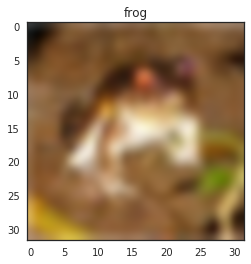

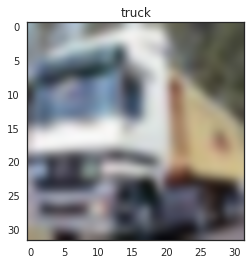

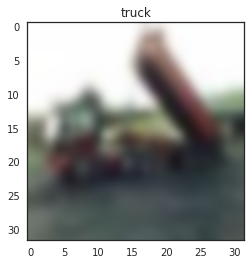

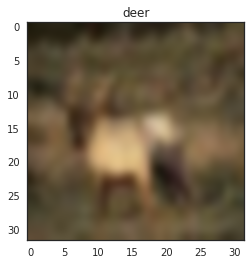

In [6]:
print(np.mean(images[0]), np.std(images[0]))

def show_whitened_image(image, label=None):
    image = unwhiten(image)
    image = image.reshape(32, 32, 3).astype("uint8")
    with sns.axes_style("white"):
        plt.imshow(image, interpolation="bicubic")
    if label:
        plt.title(label_names[label])
    plt.show()

for i in range(4):
    show_whitened_image(images[i], labels[i])

Raw
120.708
4115.23
Whitened
1.49569e-05
1.00126


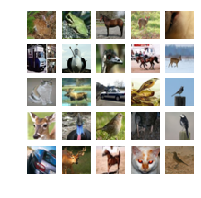

In [7]:
print("Raw")
print(np.mean(all_raw_images))
print(np.var(all_raw_images))

print("Whitened")
print(np.mean(images))
print(np.var(images))

show_images(unwhiten(images))

Whitened Test
0.0128064
0.997227


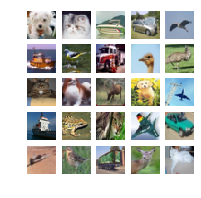

10000


In [8]:
print("Whitened Test")
print(np.mean(test_images))
print(np.var(test_images))

show_images(unwhiten(test_images))
print(len(test_images))

In [9]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

1.1.0
['/gpu:0']


In [10]:
def print_graph_stats(verbose=False):
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        if verbose:
            print('')
            print(shape)
            print(len(shape))
        variable_parametes = 1
        for dim in shape:
            if verbose:
                print(dim)
            variable_parametes *= dim.value
        if verbose:
            print(variable_parametes)
        total_parameters += variable_parametes

    print("Total params = %s" % total_parameters)


In [26]:
tf.reset_default_graph()

# Get determinism
np.random.seed(1)
random.seed(1)
tf.set_random_seed(1)

# Build our models
input_size = 3*32*32
output_size = 10
batch_size = 50 # To use GPU correctly


# Helpers
xavier = tf.contrib.layers.xavier_initializer()
def conv2d(x, W_shape, scope):
    with tf.variable_scope(scope):
        W = tf.get_variable("W", shape=W_shape, initializer=xavier)
        b = tf.Variable(tf.constant(0.1, shape=[W_shape[3]]))
        conved = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
        return tf.nn.relu(conved + b)

def max_pool_2x2(x):
    """Use this to halve the size after a conv"""
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


keep_prob = tf.placeholder(tf.float32)
lr = tf.placeholder(tf.float32)

def nin_layer(x, conv_shape, scope):
    fil_x, fil_y, in_channels, out_channels = conv_shape

    hidden_channels = 192
    with tf.variable_scope(scope):
        # Normal Conv
        conv1 = conv2d(x, [5, 5, in_channels, hidden_channels], "nin_1")

        # NIN
        conv2 = conv2d(conv1, [1, 1, hidden_channels, out_channels], "nin_2")
        return conv2


x = tf.placeholder(tf.float32, shape=(None, input_size))
y_train = tf.placeholder(tf.int32, shape=(batch_size))

x_image = tf.reshape(x, [-1, 32, 32, 3])

# Conv layer 1
h_conv1 = nin_layer(x_image, [5, 5, 3, 32], "conv_1")
h_pool1 = max_pool_2x2(h_conv1) # (16x16x32)

# Conv layer 2
h_conv2 = nin_layer(h_pool1, [3, 3, 32, 32], "conv_2")
h_pool2 = max_pool_2x2(h_conv2) # (8x8x32)

# Conv layer 3
h_conv3 = nin_layer(h_pool2, [3, 3, 32, 10], "conv_3") # (8x8x10)

# Global meanpool
logits = tf.reduce_mean(h_conv3, axis=(1,2)) # (10)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_train, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Optimizers
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    # Ensures that we execute the update_ops before performing the train_step
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#         optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimizer.minimize(loss, global_step=global_step)

#################################
### Finished defining graph
#################################

print_graph_stats(False)
print("Graph ready")


def check_accuracy(test_ims, test_ys, sess):    
    total_correct = 0
    for i in range(len(test_ims) // batch_size):
        logits_out = sess.run(logits, feed_dict={
            x: test_ims[i*batch_size:(i+1)*batch_size],
            keep_prob: 1.0,
        })
        y_pred = np.argmax(logits_out, 1)
        correct = (y_pred - test_ys[i*batch_size:(i+1)*batch_size]) == 0
        total_correct += correct

    acc = np.sum(total_correct) / len(test_ys)

    message = "%s correct out of %s => accuracy: %s" % ( np.sum(total_correct), len(test_ys), acc)
    return acc, message
    
#################################
### Start training
#################################

report = {
    'loss': [],
    'val_acc': [],
}

n_epochs = 20

annealing_lr = 2*10e-5
sess = tf.InteractiveSession()
def sample(images, labels, n=50):
    sample_indices = random.sample(range(len(images)), n)
    return images[sample_indices], labels[sample_indices]

# Initialize
sess.run(tf.global_variables_initializer()) # This always sets the same values

print("Starting training...")
start = datetime.now()
for epoch in range(n_epochs):
    for i in range(1000):
        train_ims, train_labels = sample(images, labels)

        _, l = sess.run([train_op, loss], feed_dict={
            x: train_ims,
            y_train: train_labels,
            keep_prob: 0.5,
            lr: annealing_lr
        })

        if i % 50 == 0:
            report['loss'].append(l)
            acc, acc_msg = check_accuracy(*sample(val_images, val_labels, 1000), sess)

            report['val_acc'].append(acc)

    report['val_acc'].append(acc)
    print("\nepoch: %s   lr: %s   loss: %s" % (epoch, annealing_lr, l))
    print(acc_msg)

#     if epoch != 0 and epoch % 10 == 0:
#         annealing_lr /= 10.
#         print("Annealed lr to %s" % annealing_lr)

training_time = datetime.now() - start
print("Training time: %s" % training_time)

acc, _ = check_accuracy(test_images, test_labels, sess)
print("Final test accuracy: %.1f%%" % (acc*100))

Total params = 336458
Graph ready
Starting training...

epoch: 0   lr: 0.0002   loss: 1.50189
472 correct out of 1000 => accuracy: 0.472

epoch: 1   lr: 0.0002   loss: 1.06858
519 correct out of 1000 => accuracy: 0.519

epoch: 2   lr: 0.0002   loss: 1.11893
591 correct out of 1000 => accuracy: 0.591

epoch: 3   lr: 0.0002   loss: 0.918409
622 correct out of 1000 => accuracy: 0.622

epoch: 4   lr: 0.0002   loss: 1.05361
671 correct out of 1000 => accuracy: 0.671

epoch: 5   lr: 0.0002   loss: 1.21008
651 correct out of 1000 => accuracy: 0.651

epoch: 6   lr: 0.0002   loss: 0.979461
686 correct out of 1000 => accuracy: 0.686

epoch: 7   lr: 0.0002   loss: 0.964655
701 correct out of 1000 => accuracy: 0.701

epoch: 8   lr: 0.0002   loss: 0.74596
710 correct out of 1000 => accuracy: 0.71

epoch: 9   lr: 0.0002   loss: 0.713744
719 correct out of 1000 => accuracy: 0.719

epoch: 10   lr: 0.0002   loss: 0.841514
737 correct out of 1000 => accuracy: 0.737

epoch: 11   lr: 0.0002   loss: 0.6728

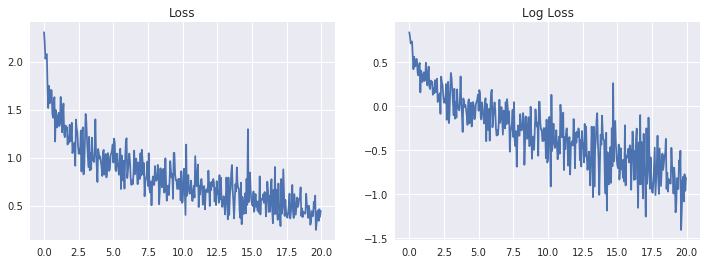

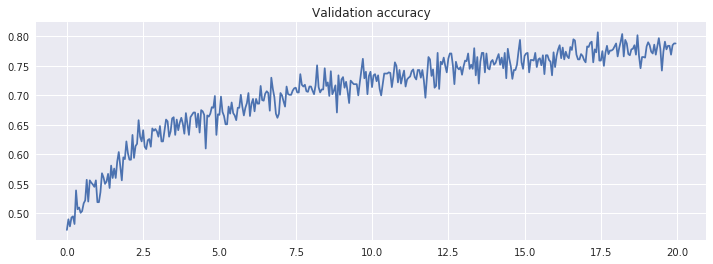

Training time: 0:10:27.198398
Final validation accuracy: 77.8%
Final test accuracy: 77.7%


In [30]:
from matplotlib import pyplot as plt
def smooth(vals):
    window = 1
    return np.convolve(vals, np.ones(window)/window, mode='valid')

xs = [log / 20 for log in range(len(report['loss']))]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(xs, smooth(report['loss']))
ax1.set_title("Loss")
ax2.plot(xs, smooth(np.log(report['loss'])))
ax2.set_title("Log Loss")
plt.show()

plt.title("Validation accuracy")
ys = smooth(report['val_acc'][20:])
plt.plot(xs, ys)
plt.show()

print("Training time: %s" % training_time)
print("Final validation accuracy: %.1f%%" % (np.mean(report['val_acc'][-10:]) *100))
print("Final test accuracy: %.1f%%" % (acc*100))

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


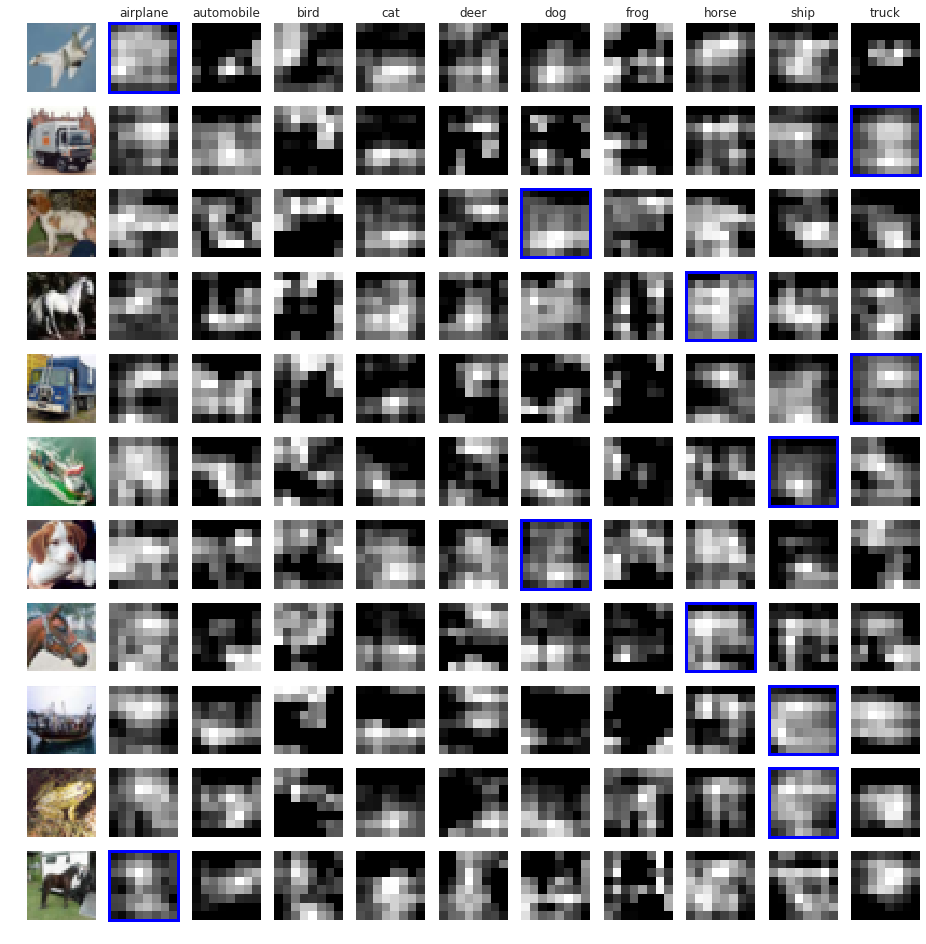

In [113]:

n = 11
offset = 10
fig, axes1 = plt.subplots(n,11, figsize=(16, 3*n/2))
for k in range(10):
    ax = axes1[0][k+1] 
    ax.set_title(label_names[k])
        
for j in range(n):
    im = unwhiten(test_images[int(j) + offset])
    
    saliency_map, logits_out = sess.run([h_conv3, logits], feed_dict={
        x: [im],
        keep_prob: 1.0,
    })
    data = im.reshape(32, 32, 3).astype('uint8')
    axes1[j][0].set_axis_off()
    axes1[j][0].imshow(data)
    
    logits_out = logits_out[0]
    y_pred = np.argmax(logits_out)
        
    for k in range(10):
        ax = axes1[j][k+1] 


        if y_pred == k:
            ax.grid(False)
            for spine in ax.spines.values():
                spine.set_edgecolor('blue')
                spine.set_linewidth(3.0)

            ax.set_yticklabels([])
            ax.set_xticklabels([])
                
        else:
            ax.set_axis_off()                
        ax.imshow(saliency_map[0, :, :, k], cmap="gray")

plt.show()


# show_whitened_image(im, y_pred)
# print(saliency_map.shape)
# with sns.axes_style('white'):
#     plt.imshow(saliency_map[:,:,y_pred], cmap="gray")



In [ ]:
# # Render misclassified data
# test_ims = test_images
# test_ys = test_labels

# total_correct = 0
# wrongs = []
# for i in range(len(test_ims) // batch_size):
#     logits_out = sess.run(logits, feed_dict={
#         x: test_ims[i*batch_size:(i+1)*batch_size],
#         keep_prob: 1.
#     })
    
#     y_pred = np.argmax(logits_out, 1)
#     incorrect_idxs, = np.where((y_pred - test_ys[i*batch_size:(i+1)*batch_size]) != 0)
#     wrongs = np.concatenate([wrongs, incorrect_idxs + batch_size*i])

In [10]:
# print("Showing broken images")
# for idx in range(100):
# # for idx in wrongs[10:20]:
#     im = test_ims[int(idx)]
#     logits_out = sess.run(logits, feed_dict={
#         x: [im],
#         keep_prob: 1.
#     })

#     show_whitened_image(im)
#     plt.title("pred: %s   actual: %s" % (label_names[np.argmax(logits_out, 1)], 
#                                          label_names[test_labels[int(idx)]]
#                                         ))


Showing broken images


NameError: name 'test_ims' is not defined